In [35]:
import mne
import scipy.io

# Load the .mat file containing electrode locations
mat_data = scipy.io.loadmat('5f_data/5F-SubjectE-160321-5St-SGLHand-HFREQ.mat')

o_data = mat_data['o']

# Access data within 'o' (assuming 'o' is the main data structure you're interested in)
id_data = o_data['id']
tag_data = o_data['tag']
samp_freq_data = o_data['sampFreq']
nS_data = o_data['nS']
marker_data = o_data['marker']
data_data = o_data['data']
chnames_data = o_data['chnames']
binsuV_data = o_data['binsuV']

eeg_data = data_data[0][0]
chnames = chnames_data[0][0]
channel_name_arrays=chnames.tolist()
channel_names = [name[0] for name in channel_name_arrays]
channel_names = [name[0] for name in channel_names]

markers = [marker[0] for marker in marker_data][0]
freq=samp_freq_data[0][0][0][0]
info = mne.create_info(channel_names, freq)
raw = mne.io.RawArray(eeg_data.T, info)

Creating RawArray with float64 data, n_channels=22, n_times=3585000
    Range : 0 ... 3584999 =      0.000 ...  3584.999 secs
Ready.


In [36]:
#raw.plot(start=40, duration=10)
for ch in raw.ch_names:
    raw.set_channel_types({ch: 'eeg'})
print(raw.get_channel_types())
channels_to_drop = ['O1', 'O2', 'A1', 'A2','X5']
#referenced
raw.set_eeg_reference(ref_channels=['A1', 'A2'])
raw = raw.pick_channels(ch_names=[ch for ch in raw.ch_names if ch not in channels_to_drop])

montage =  mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

#mne resample  
raw_resampled = raw.copy().resample(250.0, npad='auto')

['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg']
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


/var/folders/36/kdqqc2hj0vj0qz_r5mtckf700000gn/T/ipykernel_42156/509208631.py:3: RuntimeWarning: The unit for channel(s) Fp1 has changed from NA to V.
  raw.set_channel_types({ch: 'eeg'})
/var/folders/36/kdqqc2hj0vj0qz_r5mtckf700000gn/T/ipykernel_42156/509208631.py:3: RuntimeWarning: The unit for channel(s) Fp2 has changed from NA to V.
  raw.set_channel_types({ch: 'eeg'})
/var/folders/36/kdqqc2hj0vj0qz_r5mtckf700000gn/T/ipykernel_42156/509208631.py:3: RuntimeWarning: The unit for channel(s) F3 has changed from NA to V.
  raw.set_channel_types({ch: 'eeg'})
/var/folders/36/kdqqc2hj0vj0qz_r5mtckf700000gn/T/ipykernel_42156/509208631.py:3: RuntimeWarning: The unit for channel(s) F4 has changed from NA to V.
  raw.set_channel_types({ch: 'eeg'})
/var/folders/36/kdqqc2hj0vj0qz_r5mtckf700000gn/T/ipykernel_42156/509208631.py:3: RuntimeWarning: The unit for channel(s) C3 has changed from NA to V.
  raw.set_channel_types({ch: 'eeg'})
/var/folders/36/kdqqc2hj0vj0qz_r5mtckf700000gn/T/ipykernel_4215

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [37]:
#make event arr
import numpy as np
import pandas as pd
import torch

# Your data array
data_array = markers

# Initialize variables to keep track of the current value and its count
current_value = None
current_count = 0
value_counts = []
current_pos = 0

# Iterate through the data array
for pos, value in enumerate(data_array.flatten()):
    if value == current_value:
        # Increment the count for consecutive occurrences
        current_count += 1
    else:
        # If a new value is encountered, add the previous value and count to the list
        if current_value is not None:
            value_counts.append((current_value, current_count,current_pos))
        # Reset count for the new value
        current_value = value
        current_pos = pos
        current_count = 1
        

# Add the last value and its count to the list
if current_value is not None:
    value_counts.append((current_value, current_count, current_pos))

# Create a DataFrame to present the consecutive counts in a table format
counts_table = pd.DataFrame(value_counts, columns=['Value', 'Consecutive Count','onset'])

# Print the table
print(counts_table)
csv_file_path = 'consecutive_counts.csv'

# Use the to_csv method to save the DataFrame to a CSV file
#counts_table.to_csv(csv_file_path, index=False)

positions_in_samples = counts_table[counts_table["Value"].isin ([1,2,3,4,5,0])]['onset']
positions_in_samples = (positions_in_samples / freq) * 250

events = counts_table[counts_table["Value"].isin ([1,2,3,4,5,0])]['Value']
event_arr = np.array([positions_in_samples, np.zeros(len(positions_in_samples)), events]).T.astype(int)
index_first_one = np.argmax(event_arr[:, 2] == 1)

# Keep only the rows from index_first_one and after, where the last column is 0 or 1
event_arr = event_arr[index_first_one:]

      Value  Consecutive Count    onset
0         0             148576        0
1        99               1029   148576
2         0               4013   149605
3        99               1025   153618
4         0               3014   154643
...     ...                ...      ...
1924      0               2341  3574010
1925      5               1281  3576351
1926      0                  2  3577632
1927     92               1026  3577634
1928      0               6340  3578660

[1929 rows x 3 columns]


In [38]:
event_arr

array([[ 41547,      0,      1],
       [ 42253,      0,      0],
       [ 42857,      0,      4],
       ...,
       [894087,      0,      5],
       [894408,      0,      0],
       [894665,      0,      0]])

In [39]:
import pandas as pd
#make csv
df = pd.DataFrame(event_arr, columns=['timestamps', 'source', 'target'])

for i in range(len(df['source'])):
    if i % 2 != 0:
        df['source'][i] = df['target'][i-1]
df.columns = ["ts","u","i"]


# Initialize empty lists to store edge labels and edge indices
edge_labels = []
edge_indices = []

# Iterate through the DataFrame
for index, row in df.iterrows():
    u = row['u']
    i = row['i']
    
    # Skip rows where both u and i are zero, as they don't represent edges
    
    edge_labels.append(f'u{u}_i{i}')
    edge_indices.append(index)

# Create a new DataFrame for edge labels and indices
edges_df = pd.DataFrame({'label': edge_labels, 'idx': edge_indices})

# Horizontal Concatenation (Side by Side)
new_df = pd.concat([df, edges_df], axis=1)

In [40]:
#make empty state 1
new_df['u'] = new_df['u'] + 1
new_df['i'] = new_df['i'] + 1
new_df


,ts,u,i,label,idx
0,41547,1,2,u0_i1,0
1,42253,2,1,u1_i0,1
2,42857,1,5,u0_i4,2
3,43181,5,1,u4_i0,3
4,43583,1,3,u0_i2,4
...,...,...,...,...,...
1910,893179,1,6,u0_i5,1910
1911,893502,6,1,u5_i0,1911
1912,894087,1,6,u0_i5,1912
1913,894408,6,1,u5_i0,1913


In [41]:
edgefeatures = []

# Assuming you have a NumPy array `data` with your data
data = raw_resampled.get_data()

# Assuming `new_df['ts']` contains your 'ts' values
for i in new_df['ts']:
    edgefeatures.append(data[:, i:i+251])

edgefeatures = np.array(edgefeatures)  # Convert the list to a NumPy array


In [42]:
edgefeatures.shape

(1915, 17, 251)

In [43]:
#add embeddings
import math
import torch

def positionalencoding3d(d_model, x, y, z):
    if d_model % 6 != 0:
        raise ValueError("Cannot use sin/cos positional encoding with odd dimension (got dim={:d})".format(d_model))
    
    # Calculate the positional encodings for X, Y, and Z separately
    x_encoding = torch.sin(x * (2 ** torch.arange(0, d_model, 3) / d_model))
    y_encoding = torch.cos(y * (2 ** torch.arange(1, d_model, 3) / d_model))
    z_encoding = torch.sin(z * (2 ** torch.arange(2, d_model, 3) / d_model))

    # Combine the encodings
    position_encoding = x_encoding + y_encoding + z_encoding
    
    return position_encoding


ch_names = montage.ch_names
pos = montage.get_positions()

# Specify the dimensionality of the encoding
d_model = 12
embeddings = [] 
# Calculate the positional encoding
for name in raw.ch_names:
    x=pos['ch_pos'][name][0]
    y=pos['ch_pos'][name][1]
    z=pos['ch_pos'][name][2]
    print(name,x,y)
    position_encoded = positionalencoding3d(d_model,x,y,z)
    embeddings.append(position_encoded)

embeddings = torch.stack(embeddings)


Fp1 -0.0294367 0.08391710000000001
Fp2 0.029872299999999997 0.0848959
F3 -0.0502438 0.0531112
F4 0.0518362 0.0543048
C3 -0.06535809999999999 -0.0116317
C4 0.06711790000000001 -0.0109003
P3 -0.0530073 -0.0787878
P4 0.0556667 -0.0785602
F7 -0.0702629 0.0424743
F8 0.0730431 0.0444217
T3 -0.0841611 -0.0160187
T4 0.0850799 -0.0150203
T5 -0.0724343 -0.0734527
T6 0.0730557 -0.07306829999999999
Fz 0.0003122 0.058512
Cz 0.0004009 -0.009167
Pz 0.0003247 -0.08111499999999999


In [44]:
# add 17 4 to (1915, 17, 250),17, 251, 5
edgetensor = torch.from_numpy(edgefeatures).view(17,-1)
datapoints_length = edgetensor.shape[-1]

electrode_embeddings_expanded = embeddings.unsqueeze(1).expand(-1, datapoints_length, -1)
combined_data = torch.cat((electrode_embeddings_expanded, edgetensor.unsqueeze(-1)), dim=2)
combined_data.shape

torch.Size([17, 480665, 5])

In [45]:
combined_data.view(1915, 17,-1,5).shape

torch.Size([1915, 17, 251, 5])

In [46]:
#now reshape to 1915
final_edgefeature = combined_data.view(1915, -1)   
np.save('gnnbackup/processed/ml_5f.npy', final_edgefeature)

In [47]:
new_df.to_csv('gnnbackup/processed/ml_5f.csv', index=False)

In [48]:
epochs = mne.Epochs(raw_resampled, events=event_arr, event_id=None, tmin=0, tmax=1, baseline=None, preload=True,proj=False)

Not setting metadata
1915 matching events found
No baseline correction applied


Using data from preloaded Raw for 1915 events and 251 original time points ...
0 bad epochs dropped


In [49]:
# do node feature which is erps 
nodefeatures=[]
rawerps=[]
for event in [0,1,2,3,4,5]:
    finger_tensor = torch.from_numpy(epochs[str(event)].average(picks='all').get_data()) 
    rawerps.append(finger_tensor)
    electrode_embeddings=embeddings
    electrode_embeddings_expanded = electrode_embeddings.unsqueeze(1).expand(-1, 251, -1)
  
    combined_feature = torch.cat((electrode_embeddings_expanded, finger_tensor.unsqueeze(-1)), dim=2)
    print(combined_feature.shape)
    flattened_embeddings = combined_feature.view(-1)
    print(flattened_embeddings.shape)
    flattened_embeddings_np = flattened_embeddings.detach().numpy()
    nodefeatures.append(flattened_embeddings_np)

nodefeatures_array = np.array(nodefeatures)
erps_array = np.array(rawerps)
print(nodefeatures_array.shape)
np.save('ml_5f_node.npy', nodefeatures_array)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
torch.Size([17, 251, 5])
torch.Size([21335])
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
torch.Size([17, 251, 5])
torch.Size([21335])
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
torch.Size([17, 251, 5])
torch.Size([21335])
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
torch.Size([17, 251, 5])
torch.Size([21335])
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
torch.Size([17, 251, 5])
torch.Size([21335])
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
torch.Size([17, 251, 5])
torch.Size([21335])
(6, 21335)


In [55]:
nodefeatures_array.reshape(6,-1).shape


(6, 21335)

In [56]:
final_edgefeature.reshape(1915,-1).shape

torch.Size([1915, 21335])

In [57]:
edgetensor.shape

torch.Size([17, 480665])

In [63]:
testerp = rawerps[0].detach().numpy().astype(float)

In [64]:
fft=mne.time_frequency.stft(testerp, 8, tstep=None, verbose=None)

Number of frequencies: 5
Number of time steps: 63


In [67]:
fft.shape

(17, 5, 63)

In [69]:
ffts=[]
for erp in rawerps:
    erp=erp.detach().numpy().astype(float)
    fft=mne.time_frequency.stft(erp, 8, tstep=None, verbose=None)
    ffts.append(fft)

Number of frequencies: 5
Number of time steps: 63
Number of frequencies: 5
Number of time steps: 63
Number of frequencies: 5
Number of time steps: 63
Number of frequencies: 5
Number of time steps: 63
Number of frequencies: 5
Number of time steps: 63
Number of frequencies: 5
Number of time steps: 63


In [71]:
ffts_array = np.array(ffts)

In [72]:
ffts_array.shape

(6, 17, 5, 63)

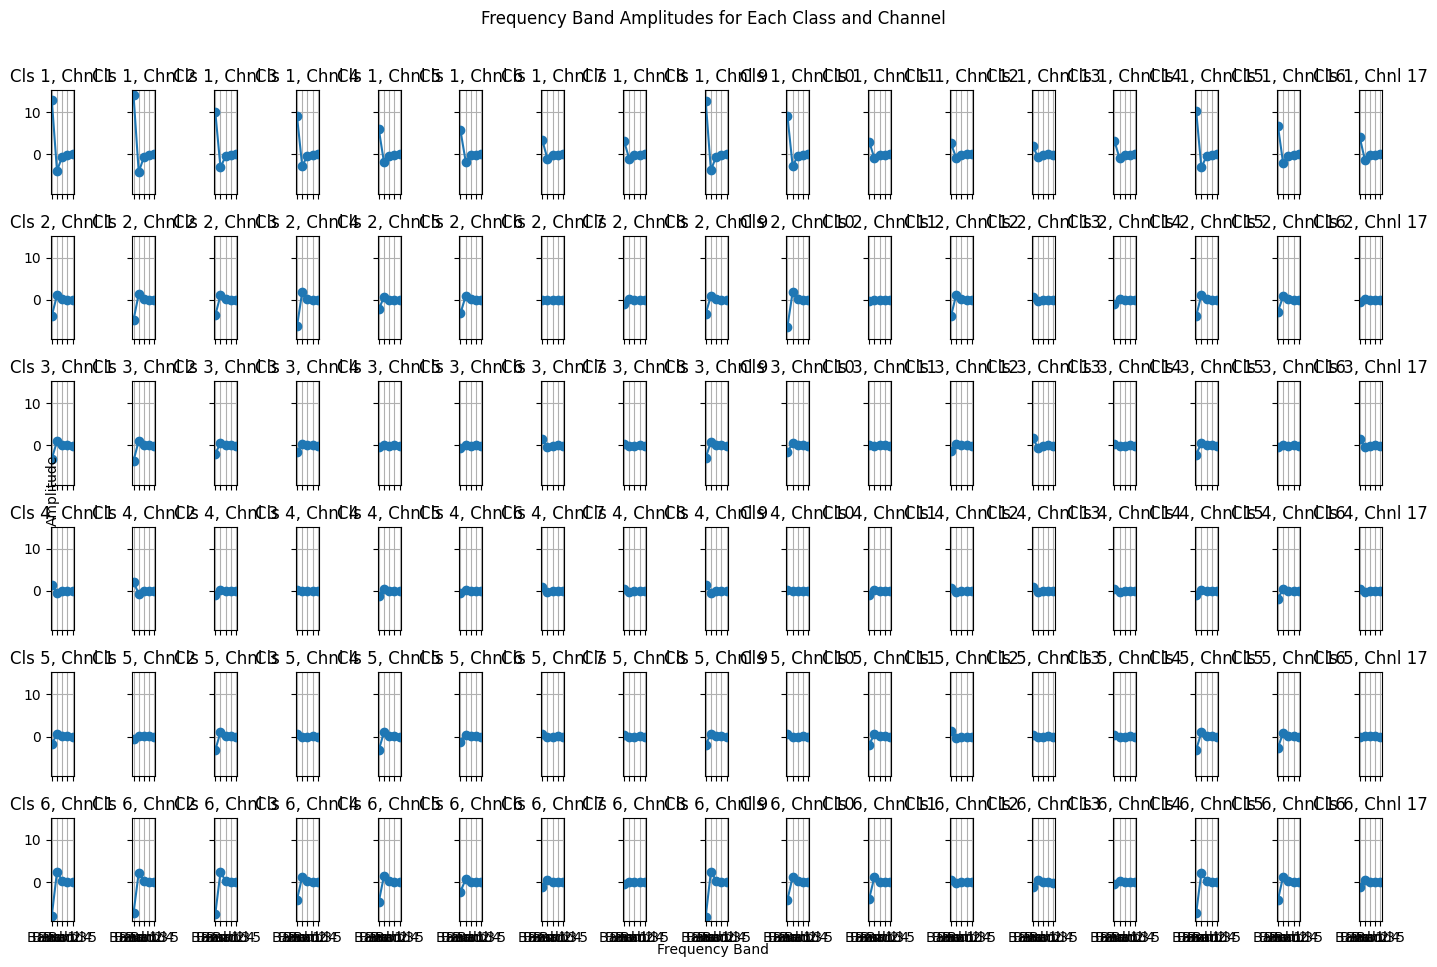

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose data is a numpy array with shape (6, 17, 5, 63)
# Replace data with your actual data array

# Averaging across timepoints
avg_data = np.mean(ffts_array, axis=-1)  # Resultant shape: (6, 17, 5)

# Define frequency bands
frequency_bands = ['Band 1', 'Band 2', 'Band 3', 'Band 4', 'Band 5']  # Replace with actual band names or ranges

# Plotting
num_classes, num_channels, _ = avg_data.shape

fig, axs = plt.subplots(num_classes, num_channels, figsize=(15, 10), sharex=True, sharey=True)

for class_idx in range(num_classes):
    for channel_idx in range(num_channels):
        axs[class_idx, channel_idx].plot(frequency_bands, avg_data[class_idx, channel_idx], marker='o')
        axs[class_idx, channel_idx].set_title(f'Cls {class_idx + 1}, Chnl {channel_idx + 1}')
        axs[class_idx, channel_idx].grid(True)

# Adding labels and title
plt.suptitle('Frequency Band Amplitudes for Each Class and Channel')
fig.text(0.5, 0.04, 'Frequency Band', ha='center', va='center')
fig.text(0.06, 0.5, 'Amplitude', ha='center', va='center', rotation='vertical')

plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.97])
plt.show()
